In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0   # not gpu numbers
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307), (0.3081))])  ## std for 2-dim 


# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True,  transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [2]:
train_data


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

/tmp/ipykernel_1606/1834221740.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


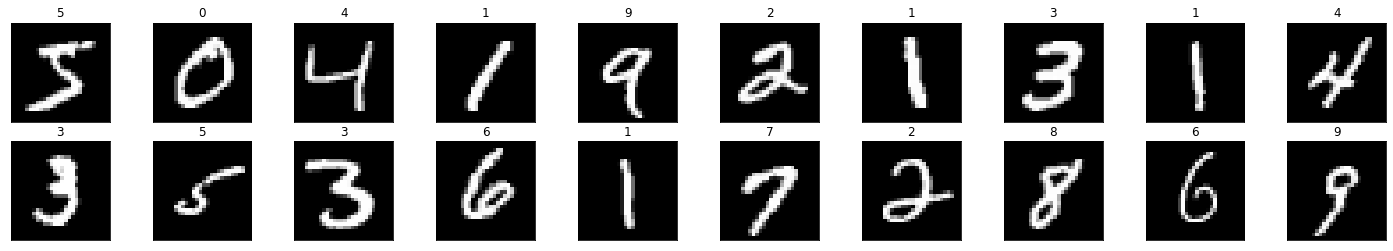

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size()) # 28 X 28
#print(images[0,:,:,:]) # negative numbers exist, # first image in the batch
#print(labels)

torch.Size([20, 1, 28, 28])


In [6]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
print(images.size())
temp = images.view(-1, 28 * 28)  # 20*28*28 / (28*28)
print(temp.size())               # transforming the 2-D image to 1-D vector

torch.Size([20, 1, 28, 28])
torch.Size([20, 784])


In [8]:
print(model.fc1)
print(model.fc1.weight)



Linear(in_features=784, out_features=512, bias=True)
Parameter containing:
tensor([[ 0.0203,  0.0186, -0.0262,  ..., -0.0265, -0.0300, -0.0157],
        [-0.0266, -0.0320, -0.0201,  ...,  0.0274, -0.0207, -0.0260],
        [-0.0046, -0.0057,  0.0189,  ..., -0.0199,  0.0174,  0.0293],
        ...,
        [ 0.0310,  0.0281,  0.0074,  ...,  0.0106, -0.0242, -0.0023],
        [ 0.0194,  0.0208, -0.0033,  ...,  0.0310, -0.0123, -0.0067],
        [-0.0143, -0.0157,  0.0326,  ...,  0.0355, -0.0357,  0.0300]],
       requires_grad=True)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
# per epoch, all the training data set is used once


model.train() # prep model for training


for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0) # as loss is tensor, .item() needed to get the value
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss)) ## printing command

Epoch: 1 	Training Loss: 0.647870
Epoch: 2 	Training Loss: 0.402128
Epoch: 3 	Training Loss: 0.351409
Epoch: 4 	Training Loss: 0.323380
Epoch: 5 	Training Loss: 0.305060
Epoch: 6 	Training Loss: 0.291769
Epoch: 7 	Training Loss: 0.281453
Epoch: 8 	Training Loss: 0.273183
Epoch: 9 	Training Loss: 0.266517
Epoch: 10 	Training Loss: 0.260871


In [22]:
print(f'Epoch: {epoch} \tTraining Loss: {train_loss}') ## printing command

Epoch: 9 	Training Loss: 0.2877039649238965


In [ ]:
model.eval()  ## prepare for evaluation

test_loss = 0
correct = 0

with torch.no_grad():  # disabling the gradient calculation
    for data, target in test_loader:     ### using "test_loader" for evaluation
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
print(output)  # Not clean one hot encoding, # no negative numbers
#print(output.size())

In [ ]:
print(output.size())
pred = output.argmax(dim=1, keepdim=True)
print(pred)

In [ ]:
print(pred.size())
print(target.size())
print(    target.view_as(pred).size()   )

In [ ]:
print(     pred.eq(   target.view_as(pred)  )             )
print(     pred.eq(target.view_as(pred)).sum().item()     )